In [34]:
%matplotlib inline
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
import json
import pandas as pd
import matplotlib as mpl

#mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from mpltools import style
from matplotlib import dates
from datetime import datetime
import seaborn as sns
import time
import os
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

In [35]:
# Seaborn plots
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
# for R lovers :)
style.use('ggplot')
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 7
# rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = False
rcParams['figure.figsize'] = 20, 10

In [36]:
access_token = "221085452-JpzdsvDoqh5xswyAb2HPHt4oPQxX5S8IP4OHbaGo"
access_token_secret = "fiLvFHqV3HK0aYiSyD75IpxeUNhYqW7ccdsDzLvIRzE6D"
consumer_key = "AhnQ75Njvid1E0F5OfDka0Mdy"
consumer_secret = "Gza45JFyy6bAEMkZWGx4Edk3yT70lE6cl0nwHKun823lk71cbf"


In [37]:
MAX_TWEETS = 1000

In [38]:
# This handles Twitter authentication and the connection to Twitter Streaming API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = API(auth, wait_on_rate_limit=True)

In [39]:
# hashtag #mozsprint 

data = Cursor(api.search, q='IChoosePeaceUG').items(MAX_TWEETS)

In [40]:
IChoosePeace_data = []
# You will use this line in production instead of this
# current_working_dir = os.path.dirname(os.path.realpath(__file__))
current_working_dir = "./"
log_tweets = current_working_dir  + str(time.time()) + '_IChoosePeace.txt'
with open(log_tweets, 'w') as outfile:
    for tweet in data:
        IChoosePeace_data.append(json.loads(json.dumps(tweet._json)))
        outfile.write(json.dumps(tweet._json))
        outfile.write("\n")

In [41]:
print(IChoosePeace_data[0])

{u'contributors': None, u'truncated': False, u'text': u'#IChoosePeaceUG. #UgandaDecides. https://t.co/g4yy0XtCTh', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 698083826824830976L, u'favorite_count': 0, u'source': u'<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [], u'hashtags': [{u'indices': [0, 15], u'text': u'IChoosePeaceUG'}, {u'indices': [17, 31], u'text': u'UgandaDecides'}], u'urls': [{u'url': u'https://t.co/g4yy0XtCTh', u'indices': [33, 56], u'expanded_url': u'http://fb.me/vidayjx6', u'display_url': u'fb.me/vidayjx6'}]}, u'in_reply_to_screen_name': None, u'id_str': u'698083826824830976', u'retweet_count': 0, u'in_reply_to_user_id': None, u'favorited': False, u'user': {u'follow_request_sent': False, u'has_extended_profile': True, u'profile_use_background_image': True, u'id': 2450209712L, u'verified': False, u'profile_text_color': u'333333', u'pr

In [42]:
# Create the dataframe we will use
tweets = pd.DataFrame()
# We want to know when a tweet was sent  #NB: use list(map()) to convert map object into data
tweets['created_at'] = map(lambda tweet: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
                                , IChoosePeace_data)
# Who is the tweet owner
tweets['user'] = map(lambda tweet: tweet['user']['screen_name'], IChoosePeace_data)
# How many follower this user has
tweets['user_followers_count'] = map(lambda tweet: tweet['user']['followers_count'], IChoosePeace_data)
# What is the tweet's content
tweets['text'] = map(lambda tweet: tweet['text'].encode('utf-8'), IChoosePeace_data)
# If available what is the language the tweet is written in
tweets['lang'] = map(lambda tweet: tweet['lang'], IChoosePeace_data)
# If available, where was the tweet sent from ?
tweets['Location'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, IChoosePeace_data)
# How many times this tweet was retweeted and favorited
tweets['retweet_count'] = map(lambda tweet: tweet['retweet_count'], IChoosePeace_data)
tweets['favorite_count'] = map(lambda tweet: tweet['favorite_count'], IChoosePeace_data)

In [43]:
print(tweets.head())

            created_at            user  user_followers_count  \
0  2016-02-12 09:58:48  Desirekarakire                   399   
1  2016-02-12 09:53:01   UrbanTVUganda                 57528   
2  2016-02-12 09:50:17        dzyre256                  2071   
3  2016-02-12 09:36:02    PEnelopetuts                   766   
4  2016-02-12 09:34:31      NizoNizayi                    99   

                                                text lang Location  \
0  #IChoosePeaceUG. #UgandaDecides. https://t.co/...  und     None   
1  RT @dzyre256: Awesome story, this. We as Ugand...   en     None   
2  Awesome story, this. We as Ugandans could use ...   en     None   
3  RT @IChoosePeaceUG: Can I make a PEACE Scream,...   en     None   
4  RT @UrbanTVUganda: On POLITICKING - #IChoosePe...   en     None   

   retweet_count  favorite_count  
0              0               0  
1              1               0  
2              1               0  
3              2               0  
4              8   

## Awesome, it looks like a table we can use now. You will notice that some tweets start with RT which is a retweet, so this may create a bias if we want to now the number of original tweets and the number of retweets.

In [44]:
#element.startswith(b'RT') because we are dealing with bytes and not strings

list_of_original_tweets = [element for element in tweets['text'].values if not element.startswith('RT')]
print(list_of_original_tweets[0])


#IChoosePeaceUG. #UgandaDecides. https://t.co/g4yy0XtCTh


In [45]:
#print number of original tweets
print("Number of Original Tweets : " + str(len(list_of_original_tweets)))


Number of Original Tweets : 331


In [46]:
list_of_retweets = [element for element in tweets['text'].values if element.startswith('RT')]
print(list_of_retweets[0])
print("Number of Retweets : " + str(len(list_of_retweets)))


RT @dzyre256: Awesome story, this. We as Ugandans could use this example going into #UgandaDecides. #iChoosePeaceUG @UrbanTVUganda https://…
Number of Retweets : 669


# Tweets visualization

### Ok now let's create some function to see some data. We will create that generic function that I will discuss in a few mooment, let's look at it first

In [47]:
# General plotting function for the different information extracted
def plot_tweets_per_category(category, title, x_title, y_title, top_n=5, output_filename="plot.png"):
    """
    :param category: Category plotted, can be tweets users, tweets language, tweets country etc ..
    :param title: Title of the plot
    :param x_title: List of the items in x
    :param y_title: Title of the variable plotted
    :return: a plot that we can save as pdf or png instead of displaying to the screen
    """
    tweets_by_cat = category.value_counts()
    fig, ax = plt.subplots()
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    tweets_by_cat[:top_n].plot(ax=ax, kind='bar')
    fig.savefig(output_filename)
    fig.show()


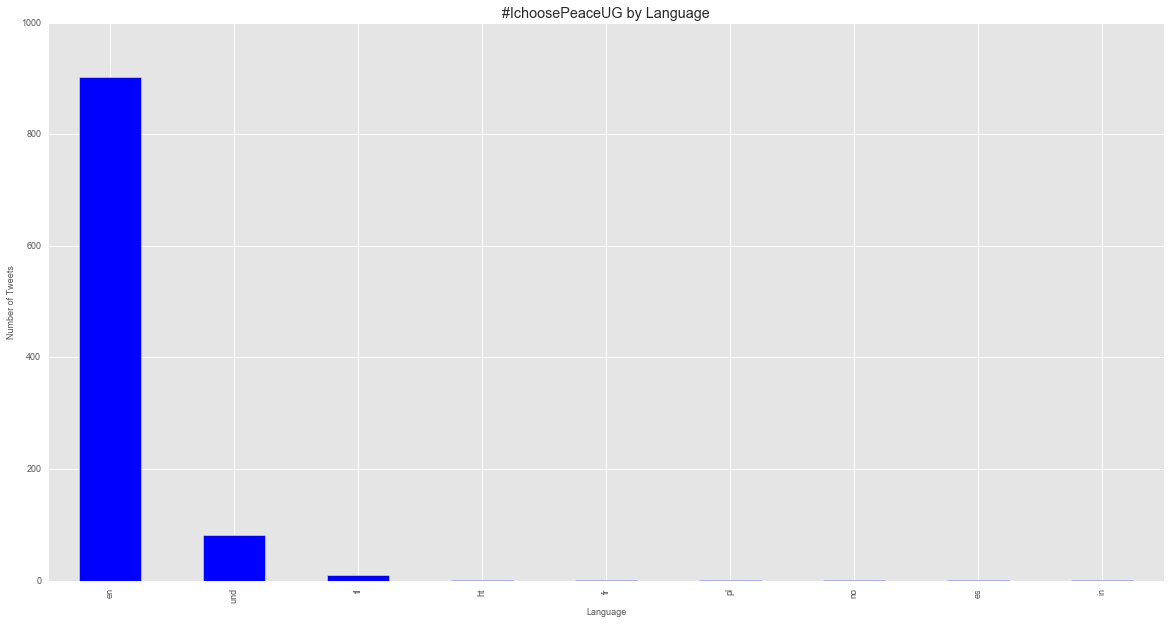

In [48]:
plot_tweets_per_category(tweets['lang'], "#IchoosePeaceUG by Language", 
                             "Language", 
                             "Number of Tweets", 
                             800,
                             "IchoosePeaceUG_per_language.png")

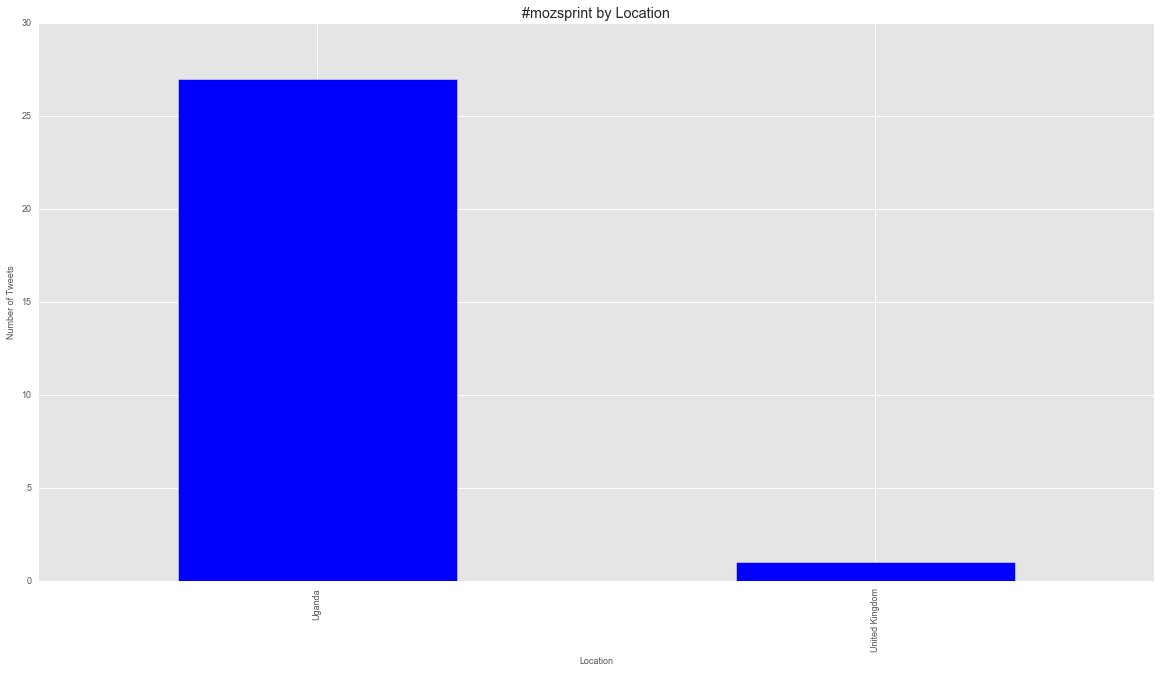

In [49]:
plot_tweets_per_category(tweets['Location'], 
                             "#mozsprint by Location", 
                             "Location", 
                             "Number of Tweets", 2000,
                             "mozsprint_per_location.png")

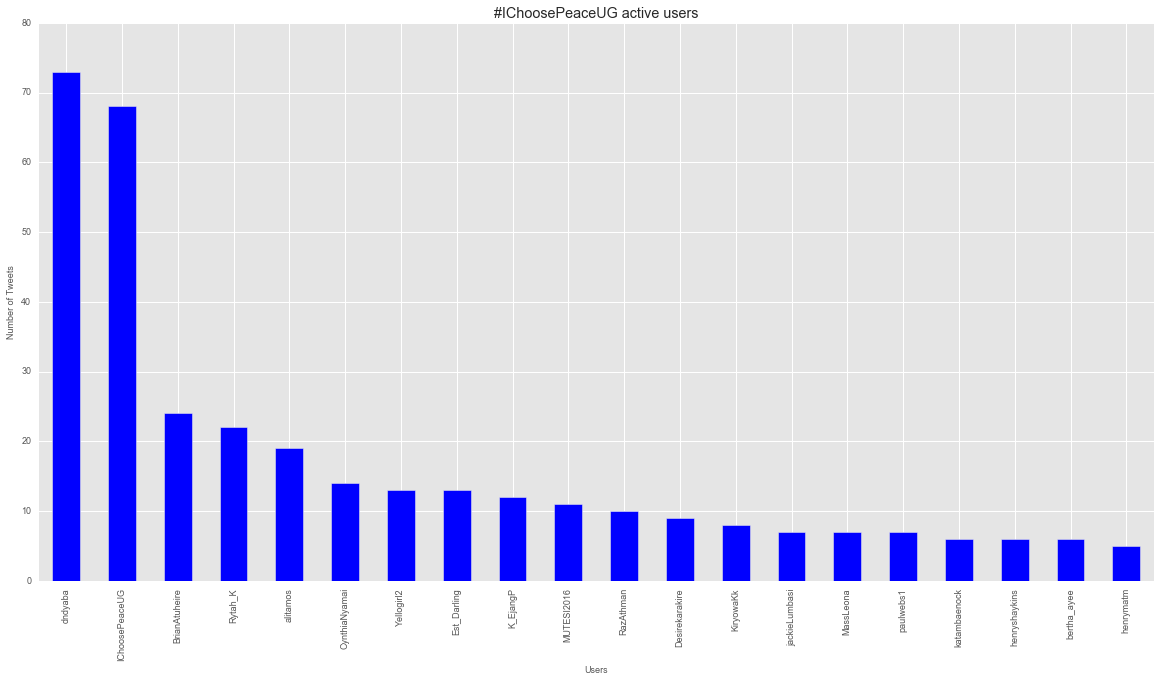

In [50]:
plot_tweets_per_category(tweets['user'], 
                             "#IChoosePeaceUG active users", 
                             "Users", 
                             "Number of Tweets", 20,
                             "mozsprint_users.png")

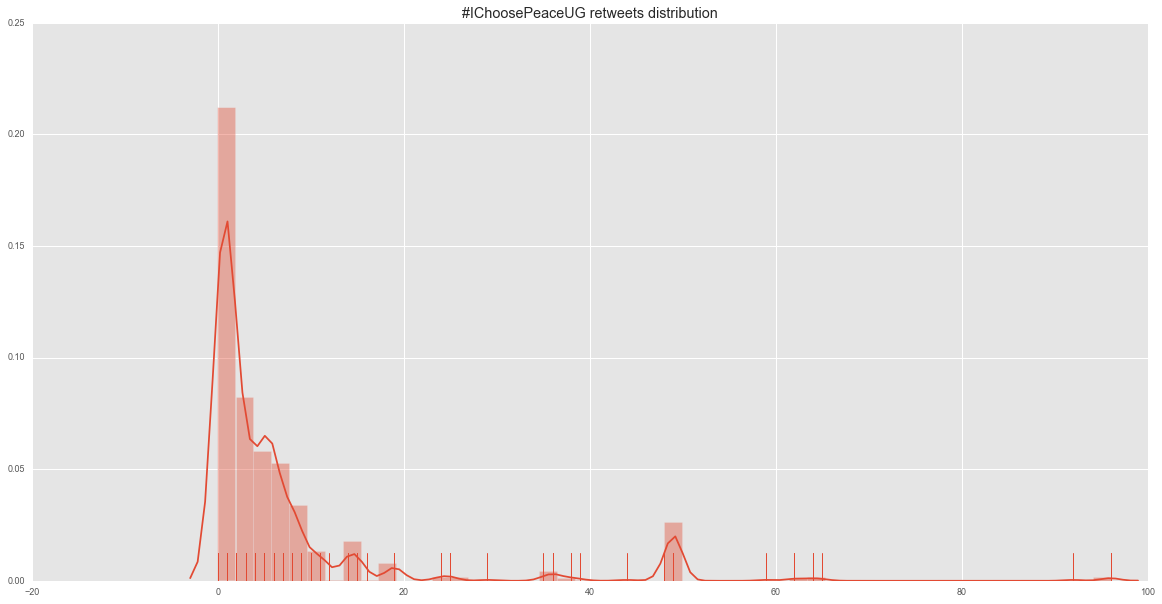

In [51]:
def plot_distribution(category, title, x_title, y_title, output_filename="plot.png"):
        """
        :param category: Category plotted, can be users, language, country etc ..
        :param title: Title of the plot
        :param x_title: List of the items in x
        :param y_title: Title of the variable plotted
        :return: a plot that we can save as pdf or png instead of displaying to the screen
        """
        fig, ax = plt.subplots()
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.set_title(title)
        sns.distplot(category.values, rug=True, hist=True);
        fig.savefig(output_filename)

plot_distribution(tweets['retweet_count'], 
                      "#IChoosePeaceUG retweets distribution", "", "",
                      "retweets_distribution.png")

# Plotting engagement data
One more thing we can examine is the trend of the tweets, in other words when people started tweeting about #mozsprint and when the peak was reached, for this we will focus on the tweet submission date column
But for that we need to transform the dates, ang group by days, and then summing the number of variables we want to plot, this is a good example of data transformation

In [83]:
df['number_tweets'] = tweets['created_at'].value_counts().head()
#df = pd.DataFrame(tweets['created_at'].value_counts(), columns=['number_tweets'])
df['date']=df.index
df.head()

,number_tweets,date
2016-02-08 10:48:28,37,2016-02-08 10:48:28
2016-02-08 07:50:53,14,2016-02-08 07:50:53
2016-02-09 06:55:59,9,2016-02-09 06:55:59
2016-02-09 19:18:03,7,2016-02-09 19:18:03
2016-02-10 09:24:03,5,2016-02-10 09:24:03


In [84]:
days = [item.split(" ")[0] for item in df['date'].values]
df['days'] = days
grouped_tweets = df[['days', 'number_tweets']].groupby('days')
tweet_growth = grouped_tweets.sum()
tweet_growth['days']= tweet_growth.index
tweet_growth

,number_tweets,days
days,,
2016-02-08,51,2016-02-08
2016-02-09,16,2016-02-09
2016-02-10,5,2016-02-10


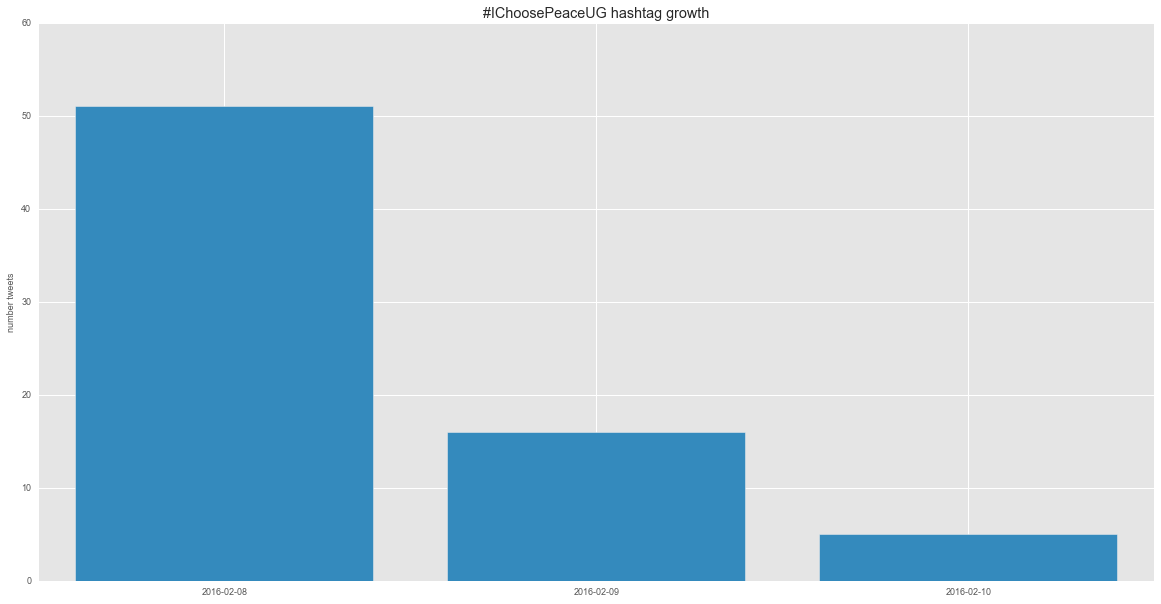

In [85]:
import numpy as np
fig = plt.figure()
ax = plt.subplot(111)
x_pos = np.arange(len(tweet_growth['days'].values))
ax.bar(x_pos, tweet_growth['number_tweets'].values, align='center')
ax.set_xticks(x_pos)
ax.set_title('#IChoosePeaceUG hashtag growth')
ax.set_ylabel("number tweets")
ax.set_xticklabels(tweet_growth['days'].values)
fig.savefig('IchoosePeaceUG_growth.png')

In [86]:
text = " ".join(tweets['text'].values.astype(str))


In [87]:
no_urls_no_tags = " ".join([word for word in text.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])

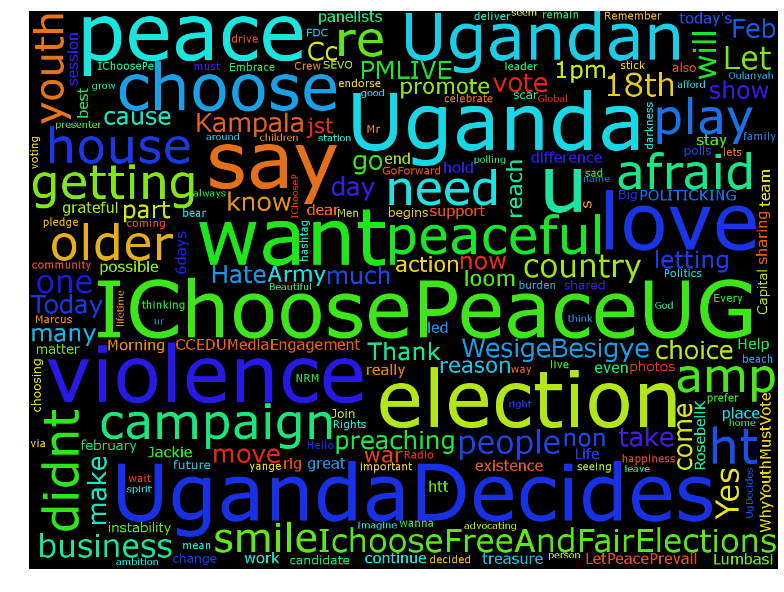

In [112]:
from PIL import Image
moz_mask = imread("./twitter_mask.png", flatten=True)

wc = WordCloud(background_color="black", font_path="C:\\Windows\\Fonts\\Verdana.ttf", stopwords=STOPWORDS, width=1800,
                          height=140, mask=moz_mask)
wc.generate(no_urls_no_tags)
plt.imshow(wc)
plt.axis("off")
plt.savefig('mozsprint.png', dpi=300)